<a href="https://colab.research.google.com/github/qamtam/Hands-on-machine-learning/blob/main/CH14_SET12_with_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#style transfer
"""ansfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network."""

#Czyli optymalizuje się docelowe zdjęcie tak, by pasowało do niektórych statystyk stylu, które się utarły w niektórych konwolucjach

import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1 #mamy w batchu 1 zdjęcie, jeśli nie to wywali błąd z assert
    tensor = tensor[0] # {1,256,256,3} -> {256,256,3}
  return PIL.Image.fromarray(tensor)


# na szybko
from random import randint
x = randint(0, 10000000000000)
random_name = str(x) + '.jpg'
print(random_name)

content_path = tf.keras.utils.get_file('waluigi.jpg', 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/screen-shot-2018-06-21-at-5-36-24-pm-1529617038.png?resize=480:*') # root tofile
style_path = tf.keras.utils.get_file(random_name, 'https://upload.wikimedia.org/wikipedia/commons/d/d3/Albert_Einstein_Head.jpg')




6503175074104.jpg
2310144/2309396 [==============================] - 0s 0us/step


tf.Tensor([219 480   3], shape=(3,), dtype=int32)
tf.Tensor([  1 233 512   3], shape=(4,), dtype=int32)
tf.Tensor([4333 3250    3], shape=(3,), dtype=int32)
tf.Tensor([  1 512 384   3], shape=(4,), dtype=int32)


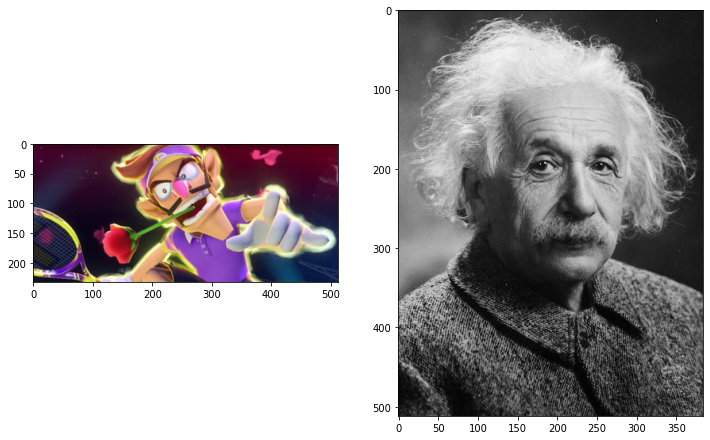

In [ ]:
#Visualize the photos
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3) # image in bytes -> Tensor
  img = tf.image.convert_image_dtype(img, tf.float32)
  print(tf.shape(img))
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  # (256,256,3) (256, 256)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :] #make it into a batch
  print(tf.shape(img))
  return img


def imshow(image, title= None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
    # squeeze pozbywa się  wymiarów rozmiaru 1
  plt.imshow(image)
  if title:
    plt.title(title)


content_image=load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2,1)
imshow(content_image)

plt.subplot(1,2,2)
imshow(style_image)

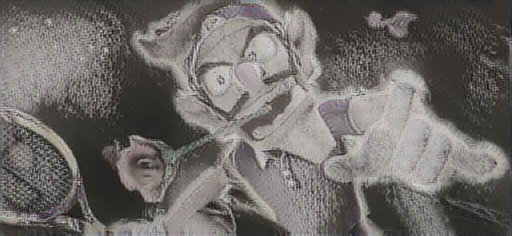

In [ ]:
#quick modification out of the box
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
# ^ actually kinda cool
# v let's get to work

# we will use some of the intermediate layers of the model to get the content  and style representations of the image
# for a new content image try to match the corresponding style and new content image representation at these intermediate layers

x = tf.keras.applications.vgg19.preprocess_input(style_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predictions = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predictions]

[('shower_curtain', 0.1777458),
 ('prayer_rug', 0.06374081),
 ('pillow', 0.059931856),
 ('sarong', 0.03589817),
 ('quilt', 0.03488279)]

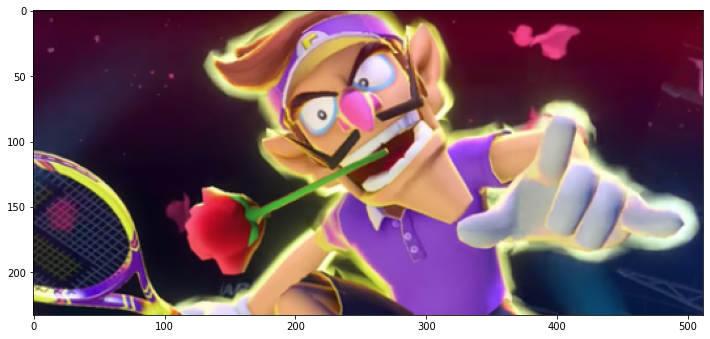

In [ ]:
imshow(content_image)

In [ ]:
# load vgg19 without classification head
vgg = tf.keras.applications.VGG19(include_top=False)
for layer in vgg.layers:
  print(layer.name)

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# let's choose some layers from the network to represent style and content of the image

content_layers = ['block5_conv2', 'block5_conv3', 'block5_conv4'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)



In [ ]:
#how does this work?
#CNN has to understand the image in order to classify it
#this understanding is captured by feature maps

#we can extract intermediate layers with Keras functional API
#to do it, you need model = Model(inputs, outputs)

def vgg_layers(layer_names):
  # creates a vgg model that then returns a list of intermediate output values
  vgg = tf.keras.applications.VGG19(False)
  vgg.trainable=False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  #print(outputs)
  model = tf.keras.Model( [vgg.input], outputs) #Functional API
  return model

style_extractor = vgg_layers(style_layers) # get layers of style
style_outputs = style_extractor(style_image*255) # style representation itself  in the form of layers


In [ ]:
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 315, 512, 64)
  min:  0.0
  max:  646.8992
  mean:  22.717537

block2_conv1
  shape:  (1, 157, 256, 128)
  min:  0.0
  max:  2639.4373
  mean:  138.12675

block3_conv1
  shape:  (1, 78, 128, 256)
  min:  0.0
  max:  7593.352
  mean:  135.59033

block4_conv1
  shape:  (1, 39, 64, 512)
  min:  0.0
  max:  15585.812
  mean:  516.8027

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  3542.877
  mean:  43.51997



In [ ]:
print(style_outputs[0]) #one of the convolution layers #64 MAPY 512*401

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 1.23684919e+00 ... 0.00000000e+00
    3.55022087e+01 3.71096909e-01]
   [0.00000000e+00 0.00000000e+00 2.68291264e+01 ... 0.00000000e+00
    1.46062073e+02 1.07943069e+02]
   [0.00000000e+00 0.00000000e+00 2.74892235e+01 ... 0.00000000e+00
    1.49872437e+02 1.23959198e+02]
   ...
   [0.00000000e+00 9.96242981e+01 1.22979408e+02 ... 0.00000000e+00
    2.92967987e+02 1.99232208e+02]
   [0.00000000e+00 1.07050797e+02 1.33939041e+02 ... 0.00000000e+00
    3.15766174e+02 2.27149979e+02]
   [9.31074524e+00 1.16893288e+02 1.99695801e+02 ... 0.00000000e+00
    5.20728210e+02 5.09427521e+02]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.68894634e+01 ... 0.00000000e+00
    5.64826660e+01 8.23838501e+01]
   [1.28940048e+01 0.00000000e+00 1.81998959e+01 ... 0.00000000e+00
    4.78244286e+01 7.85562134e+01]
   ...
   [0.00000000e+00 1.32983948e+02 1.18147209e+

In [ ]:
#style of an image can be summed into a single matrix
#so called Gram matrix

#calculates average correlation between each feature channel and puts all of that into a matrix

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor) #already a matrix, just not averaged
  input_shape = tf.shape(input_tensor)
  #to average dimensions are required
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

  

In [ ]:
#this model returns the style itself in the form of gram matrices and content of content_layers

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  def call(self, inputs):
    # expects float input in [0,1]
    inputs = inputs * 255.0 #now scale it back to get into vgg
    preprocessed_input =  tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)} #key:word
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)} #najwidoczniej nie bierze całych warstw w self.content_layers tylko nazwę?
                    # ListWrapper(['block5_conv2', 'block5_conv3', 'block5_conv4'])
    return {'content' :content_dict, 'style':style_dict}

In [ ]:
style_image * 255.0

<tf.Tensor: shape=(1, 315, 512, 3), dtype=float32, numpy=
array([[[[ 58.250004,  76.00001 , 112.50001 ],
         [ 31.000002,  46.000004, 114.00001 ],
         [ 58.25    ,  76.00001 , 116.50001 ],
         ...,
         [197.75002 , 185.      , 145.      ],
         [204.75002 , 197.      , 150.25    ],
         [202.25002 , 189.      , 148.75002 ]],

        [[ 67.5     ,  87.75001 , 123.50001 ],
         [ 51.000004,  72.75    , 142.50002 ],
         [ 35.5     ,  51.000004, 123.00001 ],
         ...,
         [201.25003 , 187.75002 , 147.5     ],
         [202.75002 , 196.50002 , 155.5     ],
         [202.25002 , 189.      , 148.75002 ]],

        [[ 78.      , 100.5     , 126.25001 ],
         [ 69.75    ,  93.50001 , 132.      ],
         [ 45.75    ,  65.75    , 123.25001 ],
         ...,
         [202.25002 , 189.      , 148.75002 ],
         [204.00002 , 200.50002 , 156.25    ],
         [203.50003 , 193.      , 149.5     ]],

        ...,

        [[ 85.00001 ,  88.25001 , 

In [ ]:
extractor = StyleContentModel(style_layers,content_layers)
results = extractor(tf.constant(content_image)) #example

print('Styles:') #still representation of content image on style layers
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.016421998
    max:  20633.11
    mean:  761.1543

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  173506.27
    mean:  21544.012

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.020156454
    max:  1097287.6
    mean:  30579.812

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  9069574.0
    mean:  358490.78

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  137176.77
    mean:  2438.9326

Contents:
   block5_conv2
    shape:  (1, 14, 32, 512)
    min:  0.0
    max:  1283.7783
    mean:  18.359343
   block5_conv3
    shape:  (1, 14, 32, 512)
    min:  0.0
    max:  427.7164
    mean:  6.9204865
   block5_conv4
    shape:  (1, 14, 32, 512)
    min:  0.0
    max:  179.64854
    mean:  1.006543


In [ ]:
#gradient targets
style_targets = extractor(style_image)['style'] #reprezentacja stylu w postaci kilku macierzy Gram
content_targets = extractor(content_image)['content'] #reprezentacja kontentu

print(content_targets)

{'block5_conv2': <tf.Tensor: shape=(1, 14, 32, 512), dtype=float32, numpy=
array([[[[  0.       ,   0.       ,  90.874664 , ...,   0.       ,
           76.61637  ,  15.228782 ],
         [  0.       ,   0.       ,  21.429216 , ...,   0.       ,
           81.63115  ,  11.617379 ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           55.56389  ,  21.55303  ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           54.458813 ,   0.       ],
         [ 21.320248 ,   0.       ,  17.807718 , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,  10.234961 , ...,   0.       ,
            0.       ,  29.609335 ]],

        [[  0.       ,   0.       ,  44.530632 , ...,   0.       ,
            0.       ,   0.4745267],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
          

In [ ]:
image = tf.Variable(content_image) #[0,1]
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0) #clip to make it for sure between 0 and 1

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4
def style_content_loss(outputs):
  style_outputs = outputs['style'] #outputs == extractor(image) =={'content' : tensor... , 'style' : tensor...}
  content_outputs = outputs['content'] #style_target == extractor(style_image)['style'], style_outputs = extractor(content_image)['style']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name]) ** 2 ) for name in style_outputs.keys()]) #MSE 
  style_loss *= style_weight / num_style_layers
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  #s= np.array(style_loss)
  #print(s)
  # c= content_loss.numpy()
  print("Content loss = {:.0f} || style_loss = {:.0f} || loss = {:.0f}".format(content_loss,style_loss, loss))
  return loss

Content loss = 0 || style_loss = 309333824 || loss = 309333824
Content loss = 5937219 || style_loss = 126058328 || loss = 131995544
Content loss = 7961021 || style_loss = 81962928 || loss = 89923952


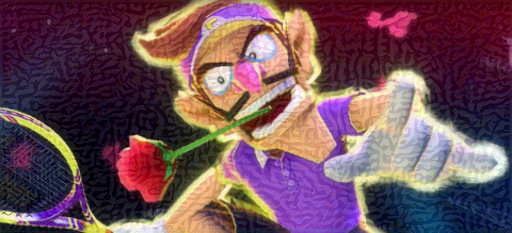

In [ ]:
#use gradient tape to update the image
#@tf.function sprawia, że najpierw to-to operuje na symbolicznych tensorach, więc nie ma wjazdu do wartości zmiennych
#tf.function # definiujemy FUNKCJĘ. Podczas definiowania nie mamy dostępnych konkretnych wartości bo ich po prostu nie ma, zatem korzysta się z  tensorów symbolicznych
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    #print(outputs['content']['block5_conv2'])
    loss = style_content_loss(outputs)
    loss += 50*tf.image.total_variation(image)
    #style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name]) ** 2 ) for name in output['style'].keys()]) #MSE 
    #print(style_loss)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image)) # gradient descent might go above 0-1

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
tf.executing_eagerly()

True

In [ ]:
x = extractor(image)

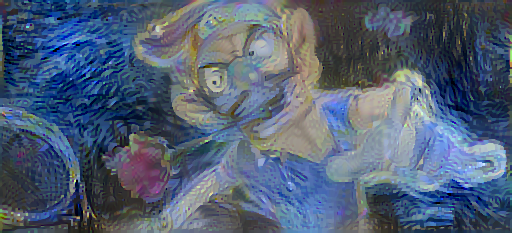

Train step: 2500
Total time: 236.6


In [ ]:
import time
start = time.time()

epochs = 25
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print("", end='\n')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))